# Control-Z Gate Sequence. Emulation using Pulser

## Introduction

In this tutorial we show how to prepare the pulse sequence that generates de *Controlled - Z* gate. We will prepare our state with atoms in any of the "digital" states that we shall call $|g\rangle$ and $|h \rangle$ ( for "ground" and "hyperfine", respectively). Then we will use the *Rydberg blockade* effect to create the logic gate. The levels that each atom can take are the following: 
<img src="files/three_states.png" alt="Three-state Configuration" style="width: 120px;"/>

We will be using *NumPy* and *Matplotlib* for calculations and plots. Additionally, we shall use the library *QuTiP* for creating several quantum objects (and also implicitly while using the simulation option in Pulser)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
from itertools import product

We import the following Classes from Pulser:

In [2]:
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.simulation import Simulation
from pulser.waveforms import BlackmanWaveform,ConstantWaveform

## 1. Loading the Register on a Pasqal Device

Defining an atom register can simply done by choosing one of the predetermined shapes included in the `Register`class. We can also construct a dictionary with specific labels for each atom. We place our atoms at a distance of $6 \mu m$ which is inside the Rydberg blockade volume

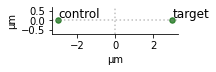

In [3]:
# Atom Register and Device
q_dict = {"control":np.array([-3.,0.]),
          "target": np.array([3.,0.]),
          }
reg = Register(q_dict)
device = Chadoq2(reg) 
reg.draw()

## 2. State Preparation

The first part of our sequence will correspond to preparing the different states on which the CZ gate will act. For this, we define the following `Pulse` instances that correspond to $\pi$ and $2\pi$ pulses (notice that the area can be easily fixed using the predefined `BlackmanWaveform`:

Let us construct a function that takes the label string (or "id") of a state and turns it into a ket state. This ket can be in any of the "digital" (ground-hyperfine levels), "ground-rydberg" or "all" levels.

In [4]:
def build_state_from_id(s_id, basis_name):
    if basis_name not in {'ground-rydberg','digital','all'}:
        raise ValueError('Not a valid basis')
        
    if basis_name == 'digital':
        pool = {''.join(x) for x in product('hg', repeat=2)}  # Gives all string labels
        if s_id not in pool:
            raise ValueError('Not a valid state id for the given basis.')
        ket = {'g' : qutip.basis(2,0),
               'h' : qutip.basis(2,1)}
    
    elif basis_name == 'ground-rydberg':
        pool = {''.join(x) for x in product('gr', repeat=2)}
        if s_id not in pool:
            raise ValueError('Not a valid state id for the given basis.')
        ket = {'r' : qutip.basis(2,0),
               'g' : qutip.basis(2,1)}
        
    elif basis_name == 'all':
        pool = {''.join(x) for x in product('hgr', repeat=2)}
        if s_id not in pool:
            raise ValueError('Not a valid state id for the given basis.')
        ket = {'r' : qutip.basis(3,0),
               'g' : qutip.basis(3,1),
               'h' : qutip.basis(3,2)}
        
    return qutip.tensor([ket[x] for x in s_id])

We try this out:

In [5]:
build_state_from_id('hg','digital')

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

Let's now write the state preparation sequence:

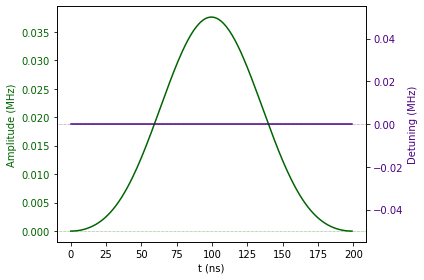

In [6]:
duration = 200
pi_Y = Pulse(BlackmanWaveform(duration,np.pi/(1000)),ConstantWaveform(duration,0),-np.pi/2)
pi_Y.draw()

In [7]:
def prep_sequence(state_id, seq, duration=200):
    if not isinstance(seq, Sequence):
        raise TypeError('Not a valid Pulser sequence.')
    
    if state_id == 'gg': 
        basis = 'ground-rydberg'
    else:
        basis = 'all'
        
    prep_state = build_state_from_id(state_id, basis)  # Will raise error if not a valid `state_id` 
    
    if state_id != 'gg':
        #    seq.delay(duration, 'raman')
        if state_id[1] == 'h': # Target will be last character in `state_id` string
            seq.declare_channel('raman','raman_local','target')
            seq.add(pi_Y,'raman') 
        if state_id[0] == 'h': 
            if 'raman' not in seq.declared_channels:
                seq.declare_channel('raman','raman_local','control')
            else:
                seq.target('control','raman')
            seq.add(pi_Y,'raman') 
    else:
        print('Warning: `gg` state does not require a preparation sequence.')
        
    return prep_state

Let's test this sequence. Notice that the state "gg" (both atoms in the ground state) is automatically fed to the Register so a pulse sequence is not needed to prepare it.

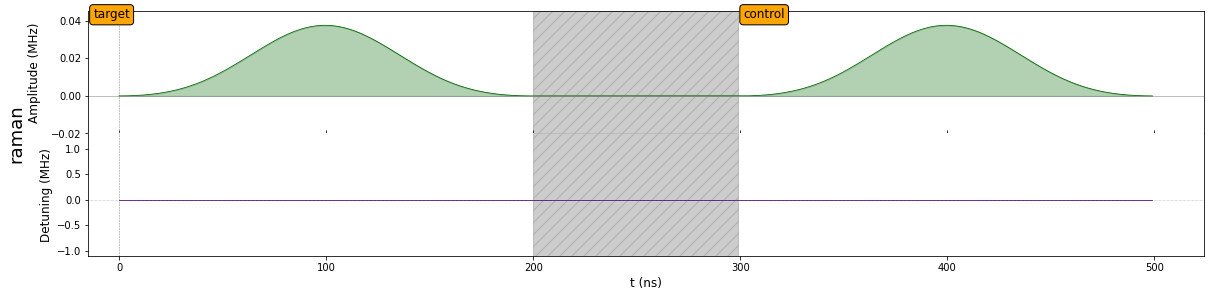

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [8]:
# Define sequence and Set channels
seq = Sequence(device)
prep_state = prep_sequence('hh',seq)
seq.draw()
print(prep_state)

## 3. Constructing the Gate Sequence

We apply the common $\pi-2\pi-\pi$ sequence for the CZ gate 

In [9]:
pi_pulse = Pulse(BlackmanWaveform(duration,np.pi/(1000)),ConstantWaveform(duration,0),0)
twopi_pulse = Pulse(BlackmanWaveform(duration,2*np.pi/(1000)),ConstantWaveform(duration,0),0)

In [10]:
def CZ_sequence(initial_id):
    # Define sequence
    seq = Sequence(device)
    
    # Prepare State
    prep_state = prep_sequence(initial_id, seq)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default=0)
    
    # Declare Rydberg channel
    seq.declare_channel('ryd_control', 'rydberg_local', 'control')
    seq.declare_channel('ryd_target', 'rydberg_local2', 'target')
    
    # Write CZ sequence:
    seq.add(pi_pulse, 'ryd_control', 'wait-for-all')  # Wait for state preparation to finish.
    seq.align('ryd_control', 'ryd_target')  # Sets starting time of target channel equal to control channel
    seq.add(twopi_pulse, 'ryd_target')
    seq.align('ryd_control', 'ryd_target')
    seq.add(pi_pulse, 'ryd_control') 

    return seq, prep_state, prep_time

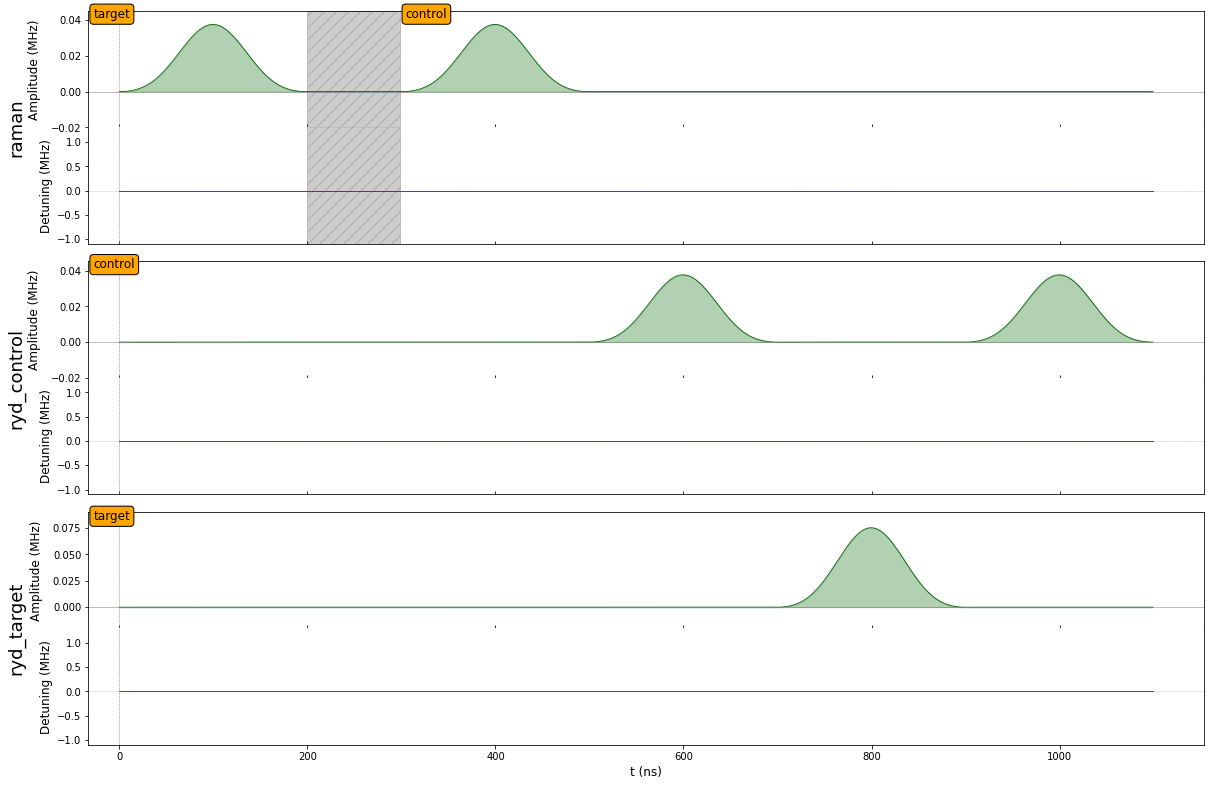

Prepared state: Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]
Preparation time: 500ns


In [11]:
seq, prep_state, prep_time = CZ_sequence('hh')
seq.draw()
print(f'Prepared state: {prep_state}')
print(f'Preparation time: {prep_time}ns')

## 4. Simulating the CZ sequence


 CZ gate sequence acting on state hh

No observable provided. Calculating state evolution...
10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.0%. Run time:   0.05s. Est. time left: 00:00:00:00
40.0%. Run time:   0.27s. Est. time left: 00:00:00:00
50.0%. Run time:   0.77s. Est. time left: 00:00:00:00
60.0%. Run time:   1.34s. Est. time left: 00:00:00:00
70.0%. Run time:   1.93s. Est. time left: 00:00:00:00
80.0%. Run time:   2.44s. Est. time left: 00:00:00:00
90.0%. Run time:   2.97s. Est. time left: 00:00:00:00
Total run time:   3.56s

 CZ gate sequence acting on state gh

No observable provided. Calculating state evolution...
10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.29s. Est. time left: 00:00:00:01
30.0%. Run time:   0.71s. Est. time left: 00:00:00:01
40.0%. Run time:   1.09s. Est. time left: 00:00:00:01
50.0%. Run time:   1.44s. Est. time left: 00:00:00:01
60.0%. Run time:   1.83s. Est. t

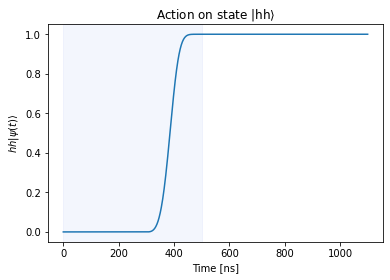

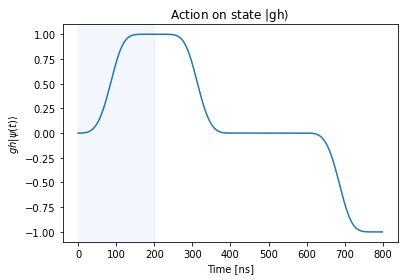

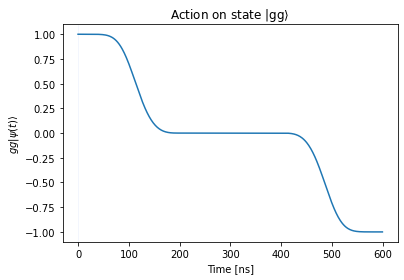

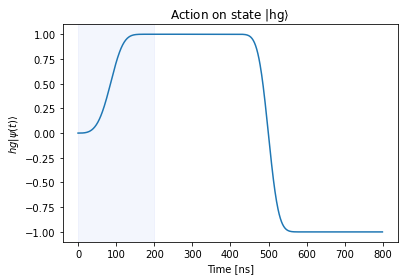

In [12]:
for state_id in {'gg','hg','gh','hh'}:
    # Get CZ sequence
    print(f"\n CZ gate sequence acting on state {state_id}\n")
    seq, prep_state, prep_time = CZ_sequence(state_id)
    
    # Construct Simulation instance
    simul = Simulation(seq)
    
    simul.run(progress_bar = True)
    
    data=[st.overlap(prep_state) for st in simul.output.states]
    
    #plt.plot(np.imag(data))
    plt.figure()
    plt.plot(np.real(data))
    plt.xlabel(r"Time [ns]")
    plt.ylabel(fr'$ {state_id} | \psi(t)\rangle$')
    plt.axvspan(0, prep_time, alpha=0.06, color='royalblue')
    plt.title(fr"Action on state $|${state_id}$\rangle$")

Let's do a short version to gather the results:

In [16]:
CZ = {}
for state_id in {''.join(x) for x in product('gh', repeat=2)}:
    seq, prep_st, prep_t = CZ_sequence(state_id)
    simul = Simulation(seq)
    simul.run()
    final_st = simul.output.states[-1]
    CZ[state_id] = final_st.overlap(prep_st)

No observable provided. Calculating state evolution...
No observable provided. Calculating state evolution...
No observable provided. Calculating state evolution...
No observable provided. Calculating state evolution...
{'hh': (0.9999999841379588-3.6739403391659387e-16j), 'gh': (-0.999999984201092+1.836970169698846e-16j), 'gg': (-0.999999790842617+0.0006359245256768003j), 'hg': (-0.9999999842010951+1.8369701696989349e-16j)}


In [17]:
CZ

{'hh': (0.9999999841379588-3.6739403391659387e-16j),
 'gh': (-0.999999984201092+1.836970169698846e-16j),
 'gg': (-0.999999790842617+0.0006359245256768003j),
 'hg': (-0.9999999842010951+1.8369701696989349e-16j)}

##  5. CCZ Gate

The same principle can be applied for composite gates. As an application, let us construct the *CCZ* gate, which determines the phase depending on the level of *two* control atoms.

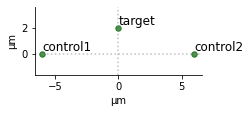

In [18]:
# Atom Register and Device
q_dict_CCZ = {"control1":np.array([-6.,0.]),
              "target": np.array([0.,2.]),
              "control2": np.array([6.,0.])}
reg_CCZ = Register(q_dict_CCZ)
device_CCZ = Chadoq2(reg_CCZ) 
reg_CCZ.draw()

In [19]:
def build_state_from_id_CCZ(s_id, basis_name):
    """ Recall that s_id = 'C1'+'C2'+'T' while in the register reg_id = 'C1'+'T'+'C2'."""
    if basis_name not in {'ground-rydberg','digital','all'}:
        raise ValueError('Not a valid basis')
        
    if basis_name == 'digital':
        pool = {''.join(x) for x in product('hg', repeat=3)}  # Gives all string labels
        if s_id not in pool:
            raise ValueError('Not a valid state id for the given basis.')
        ket = {'g' : qutip.basis(2,0),
               'h' : qutip.basis(2,1)}
    
    elif basis_name == 'ground-rydberg':
        pool = {''.join(x) for x in product('gr', repeat=3)}
        if s_id not in pool:
            raise ValueError('Not a valid state id for the given basis.')
        ket = {'r' : qutip.basis(2,0),
               'g' : qutip.basis(2,1)}
        
    elif basis_name == 'all':
        pool = {''.join(x) for x in product('hgr', repeat=3)}
        if s_id not in pool:
            raise ValueError('Not a valid state id for the given basis.')
        ket = {'r' : qutip.basis(3,0),
               'g' : qutip.basis(3,1),
               'h' : qutip.basis(3,2)}
        
    reg_id = s_id[0]+s_id[2]+s_id[1] 
    return qutip.tensor([ket[x] for x in reg_id])

In [20]:
def prep_sequence_CCZ(state_id, seq, duration=200):
    if not isinstance(seq, Sequence):
        raise TypeError('Not a valid Pulser sequence.')
    
    if state_id == 'ggg': 
        basis = 'ground-rydberg'
    else:
        basis = 'all'
        
    prep_state = build_state_from_id_CCZ(state_id, basis)  # Will raise error if not a valid `state_id` 
    
    if state_id != 'ggg':
        #    seq.delay(duration, 'raman')
        if state_id[2] == 'h': # Target will be last character in `state_id` string
            seq.declare_channel('raman','raman_local','target')
            seq.add(pi_Y,'raman') 
        if state_id[1] == 'h': 
            if 'raman' not in seq.declared_channels:
                seq.declare_channel('raman','raman_local','control2')
            else:
                seq.target('control2','raman')
            seq.add(pi_Y,'raman')
        if state_id[0] == 'h':
            if 'raman' not in seq.declared_channels:
                seq.declare_channel('raman','raman_local','control1')
            else:
                seq.target('control1','raman')
            seq.add(pi_Y,'raman')
    else:
        print('Warning: `ggg` state does not require a preparation sequence.')
        
    return prep_state

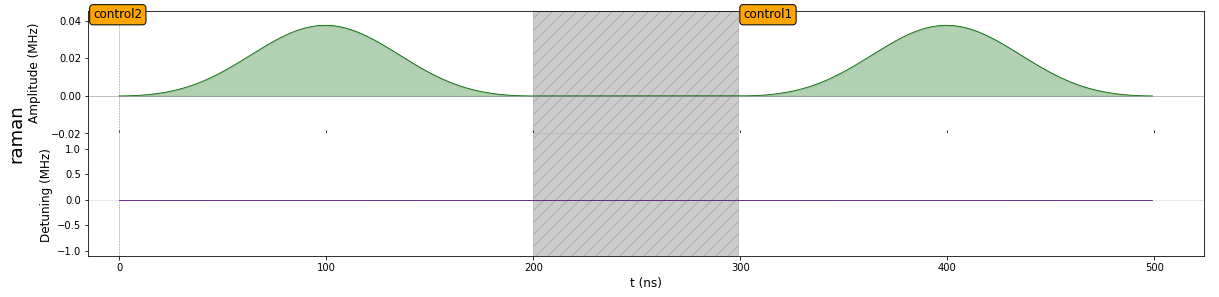

In [21]:
seq = Sequence(device_CCZ)
prep_sequence_CCZ('hhg',seq)
seq.draw()

In [22]:
def CCZ_sequence(initial_id):
    # Define sequence
    seq = Sequence(device_CCZ)
    
    # Prepare State
    prep_state = prep_sequence_CCZ(initial_id, seq)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default=0)
    
    # Declare Rydberg channel
    seq.declare_channel('rydA', 'rydberg_local', 'control1')
    seq.declare_channel('rydB', 'rydberg_local2', 'control2')
    
    # Write CZ sequence:
    seq.add(pi_pulse, 'rydA', 'wait-for-all')  # Wait for state preparation to finish.
    seq.align('rydA','rydB')
    seq.add(pi_pulse, 'rydB')
    seq.target('target','rydA')
    seq.align('rydA','rydB')
    seq.add(twopi_pulse, 'rydA')
    seq.align('rydA','rydB')
    seq.add(pi_pulse, 'rydB')
    seq.target('control1','rydA')
    seq.align('rydA','rydB')
    
    seq.add(pi_pulse,'rydA')

    return seq, prep_state, prep_time

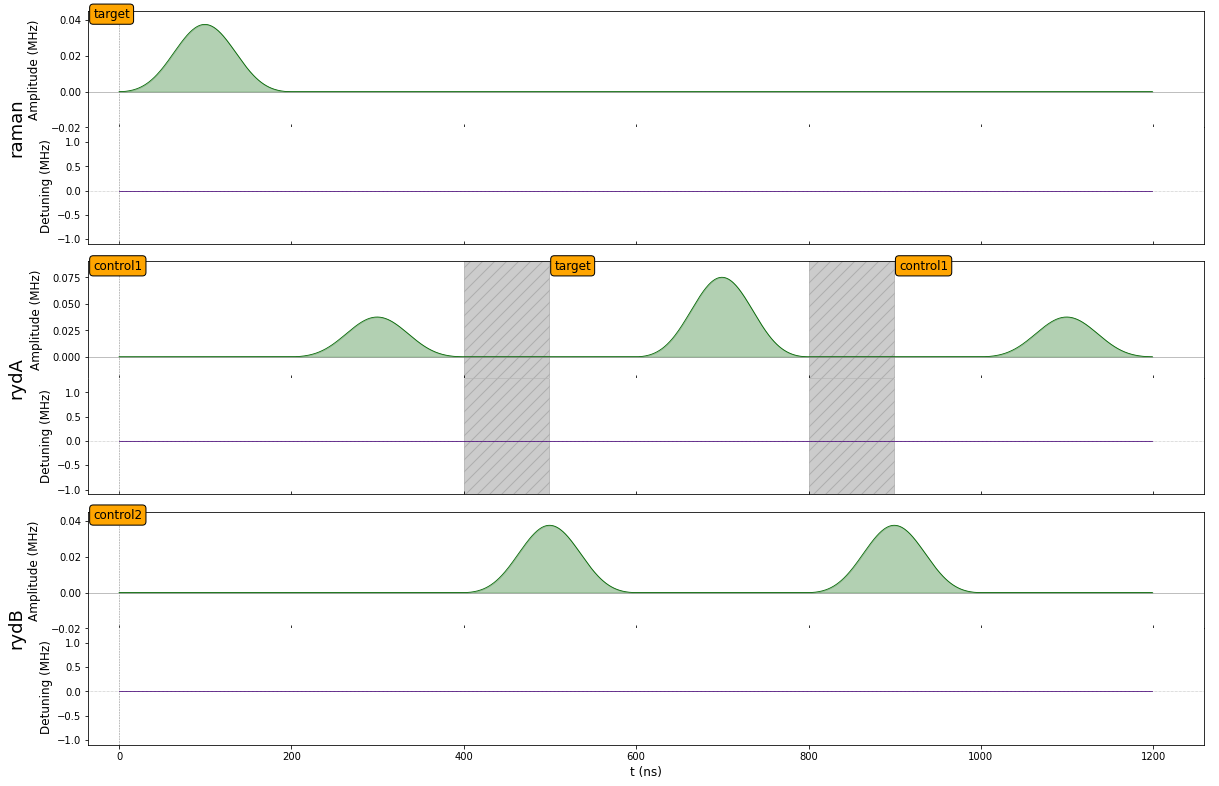

In [23]:
CCZ_seq, st, t = CCZ_sequence('ggh')
CCZ_seq.draw()


 CCZ gate sequence acting on state hhg

No observable provided. Calculating state evolution...
10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.0%. Run time:   0.07s. Est. time left: 00:00:00:00
40.0%. Run time:   0.45s. Est. time left: 00:00:00:00
50.0%. Run time:   0.84s. Est. time left: 00:00:00:00
60.0%. Run time:   1.19s. Est. time left: 00:00:00:00
70.0%. Run time:   2.16s. Est. time left: 00:00:00:00
80.0%. Run time:   3.23s. Est. time left: 00:00:00:00
90.0%. Run time:   4.34s. Est. time left: 00:00:00:00
Total run time:   5.50s

 CCZ gate sequence acting on state hhh

No observable provided. Calculating state evolution...
10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.05s. Est. time left: 00:00:00:00
30.0%. Run time:   0.08s. Est. time left: 00:00:00:00
40.0%. Run time:   0.12s. Est. time left: 00:00:00:00
50.0%. Run time:   0.55s. Est. time left: 00:00:00:00
60.0%. Run time:   1.06s. Es

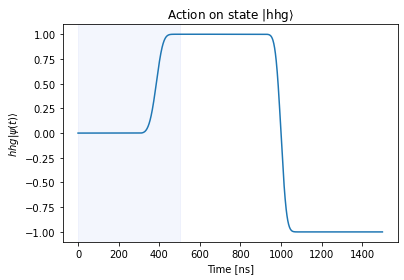

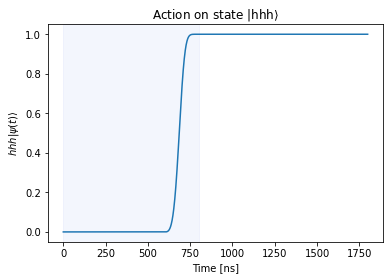

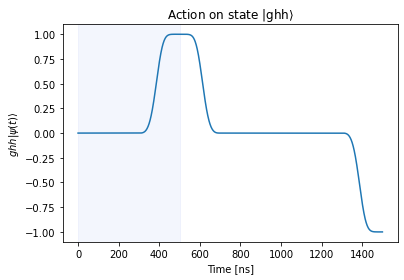

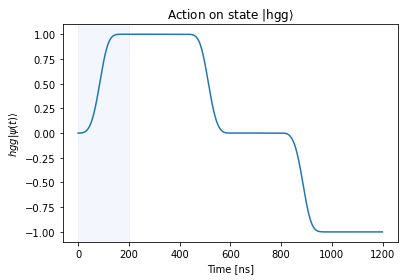

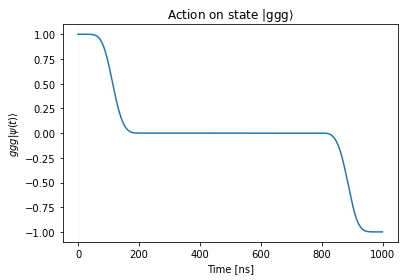

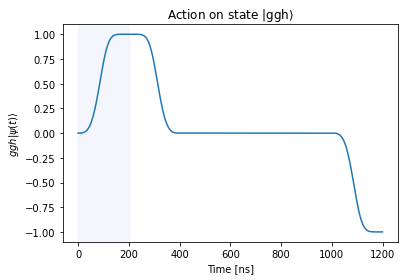

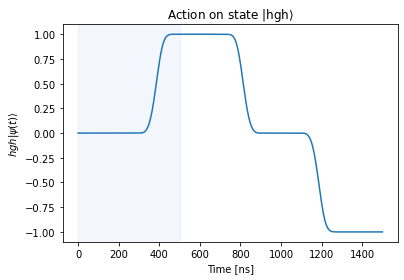

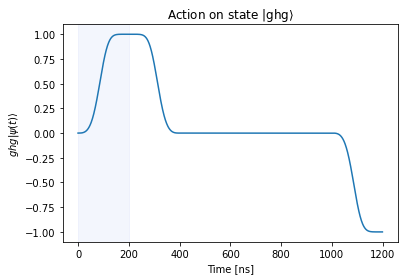

In [24]:
for state_id in {''.join(x) for x in product('gh', repeat=3)}:
    # Get CZ sequence
    print(f"\n CCZ gate sequence acting on state {state_id}\n")
    seq, prep_state, prep_time = CCZ_sequence(state_id)
    
    # Construct Simulation instance
    simul = Simulation(seq)
    
    simul.run(progress_bar = True)
    
    data=[st.overlap(prep_state) for st in simul.output.states]
    
    #plt.plot(np.imag(data))
    plt.figure()
    plt.plot(np.real(data))
    plt.xlabel(r"Time [ns]")
    plt.ylabel(fr'$ {state_id} | \psi(t)\rangle$')
    plt.axvspan(0, prep_time, alpha=0.06, color='royalblue')
    plt.title(fr"Action on state $|${state_id}$\rangle$")

In [25]:
CCZ = {}
for state_id in {''.join(x) for x in product('gh', repeat=3)}:
    seq, prep_st, prep_t = CCZ_sequence(state_id)
    simul = Simulation(seq)
    simul.run()
    final_st = simul.output.states[-1]
    CCZ[state_id] = final_st.overlap(prep_st)

No observable provided. Calculating state evolution...
No observable provided. Calculating state evolution...
No observable provided. Calculating state evolution...
No observable provided. Calculating state evolution...
No observable provided. Calculating state evolution...
No observable provided. Calculating state evolution...
No observable provided. Calculating state evolution...
No observable provided. Calculating state evolution...


Our results are as expected: only the $|hhh\rangle$ state (which corresponds to a $111$ digital state) gets its phase flipped in sign

In [26]:
CCZ

{'hhg': (-0.9999999506384825+3.67394021609082e-16j),
 'hhh': (0.9999999994878167-5.510910593340495e-16j),
 'ghh': (-0.9999999507130685+3.6739402163648047e-16j),
 'hgg': (-0.9999995703942827+0.0008723243399101488j),
 'ggg': (-0.9997747902344861+0.021221229920893786j),
 'ggh': (-0.999792889243448+0.020349093260574484j),
 'hgh': (-0.9999999533330188+3.673940225990337e-16j),
 'ghg': (-0.9999995730415383+0.0008723243422205261j)}